# Advanced Gaussian Deconvolution for FTIR
Andrew E. Ashmar | Last Updated 02/13/2024

This notebook demonstrates the concept of Gaussian deconvolution to isolate multiple different peaks in FTIR spectra. This script requires the use of the `pandas`, `matplotlib`, and `lmfit` Python packages.

## General Workflow

When using FTIR in a semi-quantitative manner, there are three steps that need to be followed:

1) **Sample Dehydration** - It is best if your sample is dehydrated prior to collecting an FTIR spectrum as water does appear in FTIR spectra. This is especially important when using FTIR to analyze the secondary structure of proteins, as the FTIR peak for water appears in the center of the Amide I spectral region.

2) **Collecting FTIR Spectra** - When collecting FTIR spectra, make sure to run a background scan prior to analyzing your sample. If you are performing an advanced deconvolution (as is shown in this script), it is best to increase the spectral resolution prior to starting the FTIR scan. I recommend changing the resolution from the default of 4 $cm^{-1}$ to either 1 $cm^{-1}$ or 0.5 $cm^{-1}$ for best results.

3)  **Analyzing Data** - While this script is useful for analyzing FTIR data, it is not foolproof. To use this script properly, you must know the precise wavelengths of each peak you would like to fit as well as the chemical feature each peak represents. This requires a thorough review of relevant scientific literature prior to data analysis.

**When analyzing data using this script, make sure to read and follow all of the prompts. This will help to ensure your results are as accurate as possible.**

## Importing Required Packages & Data

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters
from lmfit.models import GaussianModel
import datetime

# Importing demo dataset
filename = "FTIR-Sample-Data.csv"
data = pd.read_csv(filename)
amide1 = data.loc[data["wavelength"].between(1580, 1700, inclusive="both")]

## Performing Baseline Correction

In [60]:
# OPTIONAL: Plotting the amide I peak prior to baseline correction
# plt.plot(amide1["wavelength"], amide1["transmittance"])
# plt.xlabel("Wavelength (cm$^{-1}$)")
# plt.ylabel("% Transmittance")

baseWave = [1700, 1580]  # Start and end of baseline region
baseTrans = [  # Collecting transmittance at 1700 and 1600 cm^-1
    amide1["transmittance"].head(1).squeeze(),
    amide1["transmittance"].tail(1).squeeze(),
]
baseFit = np.polynomial.polynomial.polyfit(
    x=baseWave, y=baseTrans, deg=1
)  # Drawing line between points

# Correcting the baseline using the line drawn above
baseInterp = baseFit[0] + (amide1["wavelength"] * baseFit[1])
correction = amide1["transmittance"].max() - baseInterp
new = amide1["transmittance"] + correction

# Converting to '% absorbance' instead of '% transmittance'
amide1.loc[:, "absorbance"] = new.max() - new

# Splitting dataframe into variables for convenience
wave = amide1["wavelength"]
absorbance = amide1["absorbance"]

# OPTIONAL: Plotting the original and baseline-corrected data
# plt.plot(amide1["wavelength"], amide1["transmittance"])
# plt.plot(amide1["wavelength"], new)
# plt.legend(["Original Data", "Corrected Data"])
# plt.xlabel("Wavelength (cm$^{-1}$)")
# plt.ylabel("% Transmittance")

/var/folders/jd/f9fr68290s50fw4dlfh7844r0000gn/T/ipykernel_41213/207305764.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amide1.loc[:, "absorbance"] = new.max() - new


## Defining Gaussian Function
The data for an individual spectral peak can be fitted to the equation: $g(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-1(x-\mu)^2}{2\sigma^2}}$. While the Gaussian models defined in the `lmfit` package are used for parameter fitting, this function will still be useful when plotting the deconvoluted peaks.

In [61]:
def gaussian1(x, amp1, mu1, sigma1):
    # amp = amplitude
    # mu = center (mean) of the peak
    # sigma = standard deviation
    return (
        amp1
        * (1 / (sigma1 * (np.sqrt(2 * np.pi))))
        * (np.exp((-0.5) * (((x - mu1) / sigma1) ** 2)))
    )

## Creating Second-Derivative Spectrum
The easiest way to identify the location of peaks in our spectrum is to compute the second derivative of the FTIR signal, then identify the wavelengths at which peaks appear in the second derivative of the spectrum. We will do that here, while also overlaying lines showing the theoretical locations of peaks in the Amide I region.

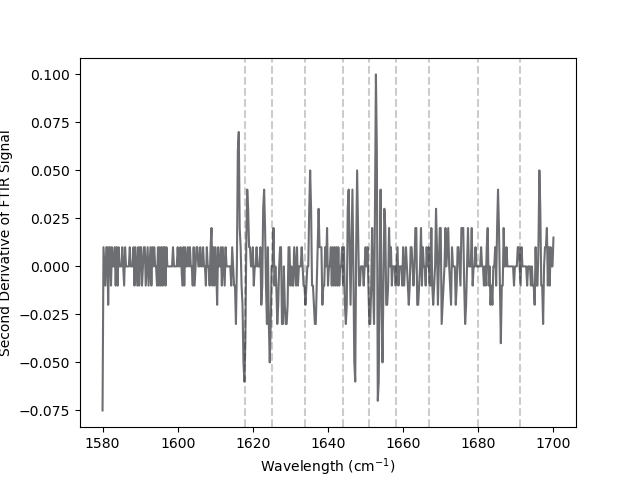

In [62]:
%matplotlib widget
diff = np.diff(a=absorbance, n=2, append=0, prepend=0)  # Computing second derivative

# Plotting the second derivative of the spectrum
diffPlot = plt.figure()
plt.plot(wave, diff, figure=diffPlot)   
plt.xlabel("Wavelength (cm$^{-1}$)")
plt.ylabel("Second Derivative of FTIR Signal")

# Plotting the theorectical peaks (from literature)
theorWaves = np.array([1618, 1625, 1634, 1644, 1651, 1658, 1667, 1680, 1691])
for _ in theorWaves:
    plt.axvline(_, color="black", linestyle="--", alpha=0.2, figure=diffPlot)
del _

## Creating Model and Fitting Data
### Establishing Initial Guesses for Parameters
Our model requires us to input initial guesses for the Gaussian parameters for each peak. The values for amplitude and sigma (`amps` and `sigmas` below) should be fine where they are. The center of each peak (values in the `mus` array below) should be manually updated to the relative locations of each peak in the second derivative plot above.

In [63]:
# Establishing best initial guesses for fit parameters
amps = np.array([50, 50, 50, 50, 50, 50, 50, 50, 50])
mus = np.array(
    [1617, 1624, 1637, 1647, 1653, 1656, 1669, 1680, 1691]
)  # INPUT: Wavelength centers (cm^-1)
sigmas = [1, 1, 1, 1, 1, 1, 1, 1, 1]

# Establishing bounds for wavelength centers (+/- 1 cm^-1)
mus_lower = mus - 1
mus_upper = mus + 1

# Creating the model as the sum of n Gaussian peaks
nPeaks = 9  # INPUT: Number of peaks in the model

model = GaussianModel(prefix="p1_")
for j in range(1, nPeaks):
    model = model + GaussianModel(prefix="p%d_" % (j + 1))

# Creating parameters to fit to the model
params = Parameters()
for i in range(0, nPeaks):
    params.add("p%d_amplitude" % (i + 1), value=amps[i], min=1)
    params.add("p%d_sigma" % (i + 1), value=sigmas[i], min=0.5, max=30)
    params.add("p%d_center" % (i + 1), value=mus[i], min=mus_lower[i], max=mus_upper[i])

# Fitting the model to the data
fitResult = model.fit(absorbance, params, x=wave, method="least_squares")

# Printing the fit results
print(fitResult.params.pretty_print())
# print(fitResult.fit_report())  # Optional: Print full fit report

# Saving best fit values to an array
optVals1 = fitResult.best_values
optVals = np.array(list(fitResult.best_values.values()))

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
p1_amplitude     321.6        1      inf      104     True     None     None
p1_center         1618     1616     1618    3.179     True     None     None
p1_sigma         12.18      0.5       30   0.8417     True     None     None
p2_amplitude     30.64        1      inf     33.1     True     None     None
p2_center         1625     1623     1625     1.19     True     None     None
p2_sigma         4.917      0.5       30    1.086     True     None     None
p3_amplitude     455.9        1      inf    163.1     True     None     None
p3_center         1636     1636     1638    3.983     True     None     None
p3_sigma         10.15      0.5       30     1.91     True     None     None
p4_amplitude     69.74        1      inf    218.9     True     None     None
p4_center         1646     1646     1648    5.166     True     None     None
p4_sigma         4.691      0.5       30     2.43     True     None     No

### Sorting and Slicing Data

In [64]:
# Saving fit parameters to variables for convenience
## Creating empty arrays for each fit parameter
optAmps = []
optMus = []
optSigmas = []

## Iterating through the fit parameters and appending to the empty arrays
for k in range(0, len(optVals), 3):
    optAmps.append(optVals[k])
    optSigmas.append(optVals[k + 1])
    optMus.append(optVals[k + 2])

# Creating y-values for the fit curves based on fit parameters
fitPeaks = np.zeros((len(optAmps), len(wave)))
for m in range(0, len(optAmps)):
    fitPeaks[m, :] = gaussian1(wave, optAmps[m], optMus[m], optSigmas[m])

## Plotting Deconvolution Results

/var/folders/jd/f9fr68290s50fw4dlfh7844r0000gn/T/ipykernel_41213/3382713156.py:34: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(legendOrder, bbox_to_anchor=(1,0), loc="lower left")


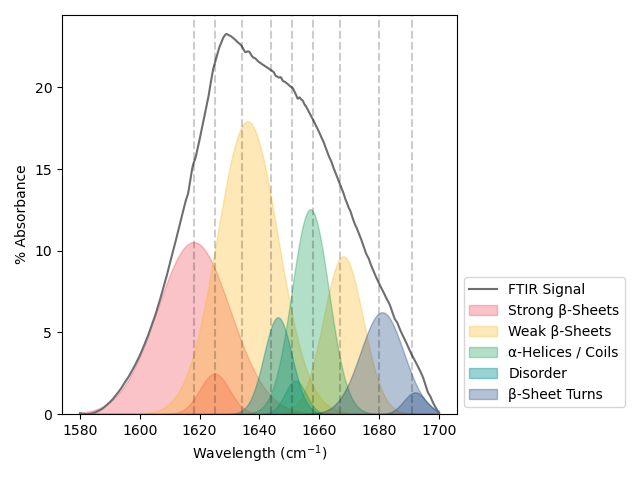

In [65]:
%matplotlib widget
finalPlot = plt.figure()
plt.plot(wave, absorbance, figure=finalPlot, color="C0")

# Plotting Strongly-Bonded Beta-Sheets
plt.fill_between(x=wave, y1=fitPeaks[7, :], alpha=0.3, color='C1', figure=finalPlot)
plt.fill_between(x=wave, y1=fitPeaks[8, :], alpha=0.3, color='C1', figure=finalPlot)

# Plotting Weakly-Bonded Beta-Sheets
plt.fill_between(x=wave, y1=fitPeaks[6, :], alpha=0.3, color='C2', figure=finalPlot)
plt.fill_between(x=wave, y1=fitPeaks[2, :], alpha=0.3, color='C2', figure=finalPlot)

# Alpha-Helices / Coils
plt.fill_between(x=wave, y1=fitPeaks[3, :], alpha=0.3, color='C3', figure=finalPlot)
plt.fill_between(x=wave, y1=fitPeaks[4, :], alpha=0.3, color='C3', figure=finalPlot)

# Disordered Regions
plt.fill_between(x=wave, y1=fitPeaks[5, :], alpha=0.4, color='C4', figure=finalPlot)

# Plotting Beta-Sheet Turns
plt.fill_between(x=wave, y1=fitPeaks[0, :], alpha=0.3, color='C5', figure=finalPlot)
plt.fill_between(x=wave, y1=fitPeaks[1, :], alpha=0.3, color='C5', figure=finalPlot)

# Plotting tabulated wavelengths for secondary structures
for o in theorWaves:
    plt.axvline(o, color="black", linestyle="--", alpha=0.2)

# Plot styling
plt.ylim(bottom=0)
plt.xlabel("Wavelength (cm$^{-1}$)")
plt.ylabel("% Absorbance")

legendOrder = ["FTIR Signal", "Strong β-Sheets", "_", "Weak β-Sheets", "_", "α-Helices / Coils", "_", "Disorder", "β-Sheet Turns", "_"]
plt.legend(legendOrder, bbox_to_anchor=(1,0), loc="lower left")
plt.tight_layout()

## Integrating Under Deconvoluted Curves

In [66]:
# Calculating area under alpha-helix curves
alphaCoils = np.trapz(y=fitPeaks[3, :], x=wave) + np.trapz(y=fitPeaks[4, :], x=wave)

disorder = np.trapz(y=fitPeaks[5, :], x=wave)  # Area under disordered region curve

# Calculating area under beta-sheet curves
strongBeta = np.trapz(y=fitPeaks[7, :], x=wave) + np.trapz(y=fitPeaks[8, :], x=wave)
weakBeta = np.trapz(y=fitPeaks[6, :], x=wave) + np.trapz(y=fitPeaks[2, :], x=wave)
betaTurns = np.trapz(y=fitPeaks[0, :], x=wave) + np.trapz(y=fitPeaks[1, :], x=wave)
totalBeta = strongBeta + weakBeta + betaTurns  # Total area under beta-sheet curves

# Calculating total area under all curves
total = alphaCoils + disorder + strongBeta + weakBeta + betaTurns

alphaPercent = alphaCoils / total * 100
betaPercent = totalBeta / total * 100
disorderPercent = disorder / total * 100

print("α-Helices: {:.2f}%".format(alphaPercent))
print("β-Sheets: {:.2f}%".format(betaPercent))
print("\tStrong β-Sheets: {:.2f}%".format(strongBeta / total * 100))
print("\tWeak β-Sheets: {:.2f}%".format(weakBeta / total * 100))
print("\tβ-Sheet Turns: {:.2f}%".format(betaTurns / total * 100))
print("Disorder: {:.2f}%".format(disorderPercent))
print("---")
print("β-Sheets: {:.2f}%".format(betaPercent))
print("Other Structures: {:.2f}%".format(alphaPercent + disorderPercent))

α-Helices: 15.39%
β-Sheets: 79.54%
	Strong β-Sheets: 25.61%
	Weak β-Sheets: 44.84%
	β-Sheet Turns: 9.09%
Disorder: 5.07%
---
β-Sheets: 79.54%
Other Structures: 20.46%


## Exporting Results

In [67]:
# Getting current date for file naming
curDate = datetime.datetime.now()

# Exporting baseline-corrected data
exportData = amide1[["wavelength", "absorbance"]]
newPath = filename[:-4] + "_BaselineCorrected.csv"
exportData.to_csv(newPath, index=False)

# Exporting fit parameters
exportParams = pd.DataFrame(
    {
        "Amplitude": optAmps,
        "Center (cm^-1)": optMus,
        "Sigma (cm^-1)": optSigmas,
    }
)
exportParams.to_csv(
    filename[:-4] + "_FitParams_" + curDate.strftime("%y%m%d") + ".csv",
    index=False,
)

# Exporting Secondary Structure Percentages
exportPcts = pd.DataFrame(
    {
        "Strong beta-Sheets": [strongBeta / total * 100],
        "Weak beta-Sheets": [weakBeta / total * 100],
        "beta-Sheet Turns": [betaTurns / total * 100],
        "alpha-Helices": [alphaPercent],
        "Disorder": [disorderPercent],
    }
)
exportPcts.to_csv(
    filename[:-4] + "_SecondaryStructureContent_" + curDate.strftime("%y%m%d") + ".csv",
    index=False,
)